In [28]:
import gym
import math
import random as rd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image

import torch as tc
from torch.autograd import Variable
from torchvision import transforms

In [93]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    env.render()
    env.step(env.action_space.sample()) # take a random action

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


In [94]:
env.close()
del(env)

In [32]:
env = gym.make('CartPole-v0').unwrapped

# setup matplotlib
plt.ion()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [33]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [34]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1)%self.capacity
        
    def sample(self, batch_size):
        return rd.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [35]:
class DQN(tc.nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = tc.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = tc.nn.BatchNorm2d(16)
        self.conv2 = tc.nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = tc.nn.BatchNorm2d(32)
        self.conv3 = tc.nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = tc.nn.BatchNorm2d(32)
        self.head = tc.nn.Linear(448, 2)
        
    def forward(self, x):
        x = tc.nn.functional.relu(self.bn1(self.conv1(x)))
        x = tc.nn.functional.relu(self.bn2(self.conv2(x)))
        x = tc.nn.functional.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [36]:
resize = transforms.Compose([transforms.ToPILImage(), transforms.Resize(40, interpolation=Image.CUBIC),
                    transforms.ToTensor()])

screen_width = 600

def get_cart_location():
    world_width = env.x_threshold*2
    scale = screen_width/world_width
    return int(env.state[0]*scale + screen_width/2.0)

def get_screen():
    screen = env.render(mode="rgb_array").transpose((2,0,1))
    screen = screen[:,160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width//2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width//2, cart_location + view_width//2)
        
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32)/255
    screen = tc.from_numpy(screen)
    return resize(screen).unsqueeze(0).type(tc.FloatTensor)

# env.reset()
# plt.figure()
# plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(), interpolation='none')
# plt.title('Example extracted screen')
# plt.show()

In [37]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = tc.optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = rd.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)*math.exp(-1.*steps_done/EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return policy_net(Variable(state, volatile=True).type(tc.FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return tc.LongTensor([[rd.randrange(2)]])
    
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = tc.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = tc.cat((tc.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)

In [38]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = tc.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    non_final_next_states = Variable(tc.cat([s for s in batch.next_state if s is not None]), volatile=True)
    
    state_batch = Variable(tc.cat(batch.state))
    action_batch = Variable(tc.cat(batch.action))
    reward_batch = Variable(tc.cat(batch.reward))
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = Variable(tc.zeros(BATCH_SIZE).type(tc.FloatTensor))
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    
    expected_state_action_values = (next_state_values*GAMMA) + reward_batch
    expected_state_action_values = Variable(expected_state_action_values.data)
    
    loss = tc.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Complete


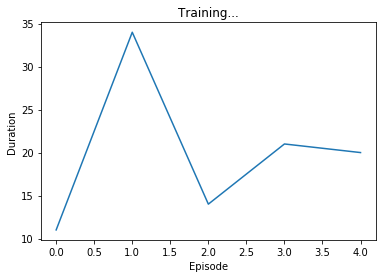

In [39]:
num_episodes = 5
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = tc.FloatTensor([reward])
        
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
# env.render(close = True)
# env.close()
plt.ioff()
plt.show()

In [41]:
env.action_space

Discrete(2)